<a href="https://colab.research.google.com/github/jfink09/optical-funduscopic-convolutional-neural-network/blob/main/FundusNeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import torch
from torch import nn

In [2]:
# Set up device for device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1.0. Get the data

In [3]:
# Import libraries
import requests
import zipfile
from pathlib import Path

data_path = Path("data")
image_path = data_path / "normal_cataracts"

# Download it and prepare image folder if it does not already exist
if image_path.is_dir():
  print(f"{image_path} directory already exists...skipping download.")
else:
  print(f"{image_path} does not exist...creating one")
  image_path.mkdir(parents=True,exist_ok=True)

# Download normal and cataracts data
with open(data_path / "normal_cataracts.zip", "wb") as f:
  request = requests.get("https://github.com/jfink09/optical-funduscopic-convolutional-neural-network/raw/main/data/normal_cataracts.zip")
  print("Downloading normal and cataracts data...")
  f.write(request.content)

# Unzip normal and cataracts data
with zipfile.ZipFile(data_path / "normal_cataracts.zip", "r") as zip_ref:
  print("Unzipping normal and cataracts data...")
  zip_ref.extractall(image_path)

data/normal_cataracts does not exist...creating one
Unzipping normal and cataracts data...


### 2.0. Data preparation and exploration

In [4]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 1 images in 'data/normal_cataracts'.
There are 2 directories and 1 images in 'data/normal_cataracts/test'.
There are 0 directories and 60 images in 'data/normal_cataracts/test/normal'.
There are 0 directories and 18 images in 'data/normal_cataracts/test/cataracts'.
There are 2 directories and 1 images in 'data/normal_cataracts/train'.
There are 0 directories and 240 images in 'data/normal_cataracts/train/normal'.
There are 0 directories and 79 images in 'data/normal_cataracts/train/cataracts'.


In [5]:
# Set up train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/normal_cataracts/train'),
 PosixPath('data/normal_cataracts/test'))

### 3.0. Visualize an image

Write code to:

1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Open the image with Python's PIL
5. Show the image and print metadata

data/normal_cataracts/train/cataracts/cataract_077.jpeg
cataracts
Random image path: data/normal_cataracts/train/cataracts/cataract_077.jpeg
Image class: cataracts
Image height: 1728
Image width: 2592


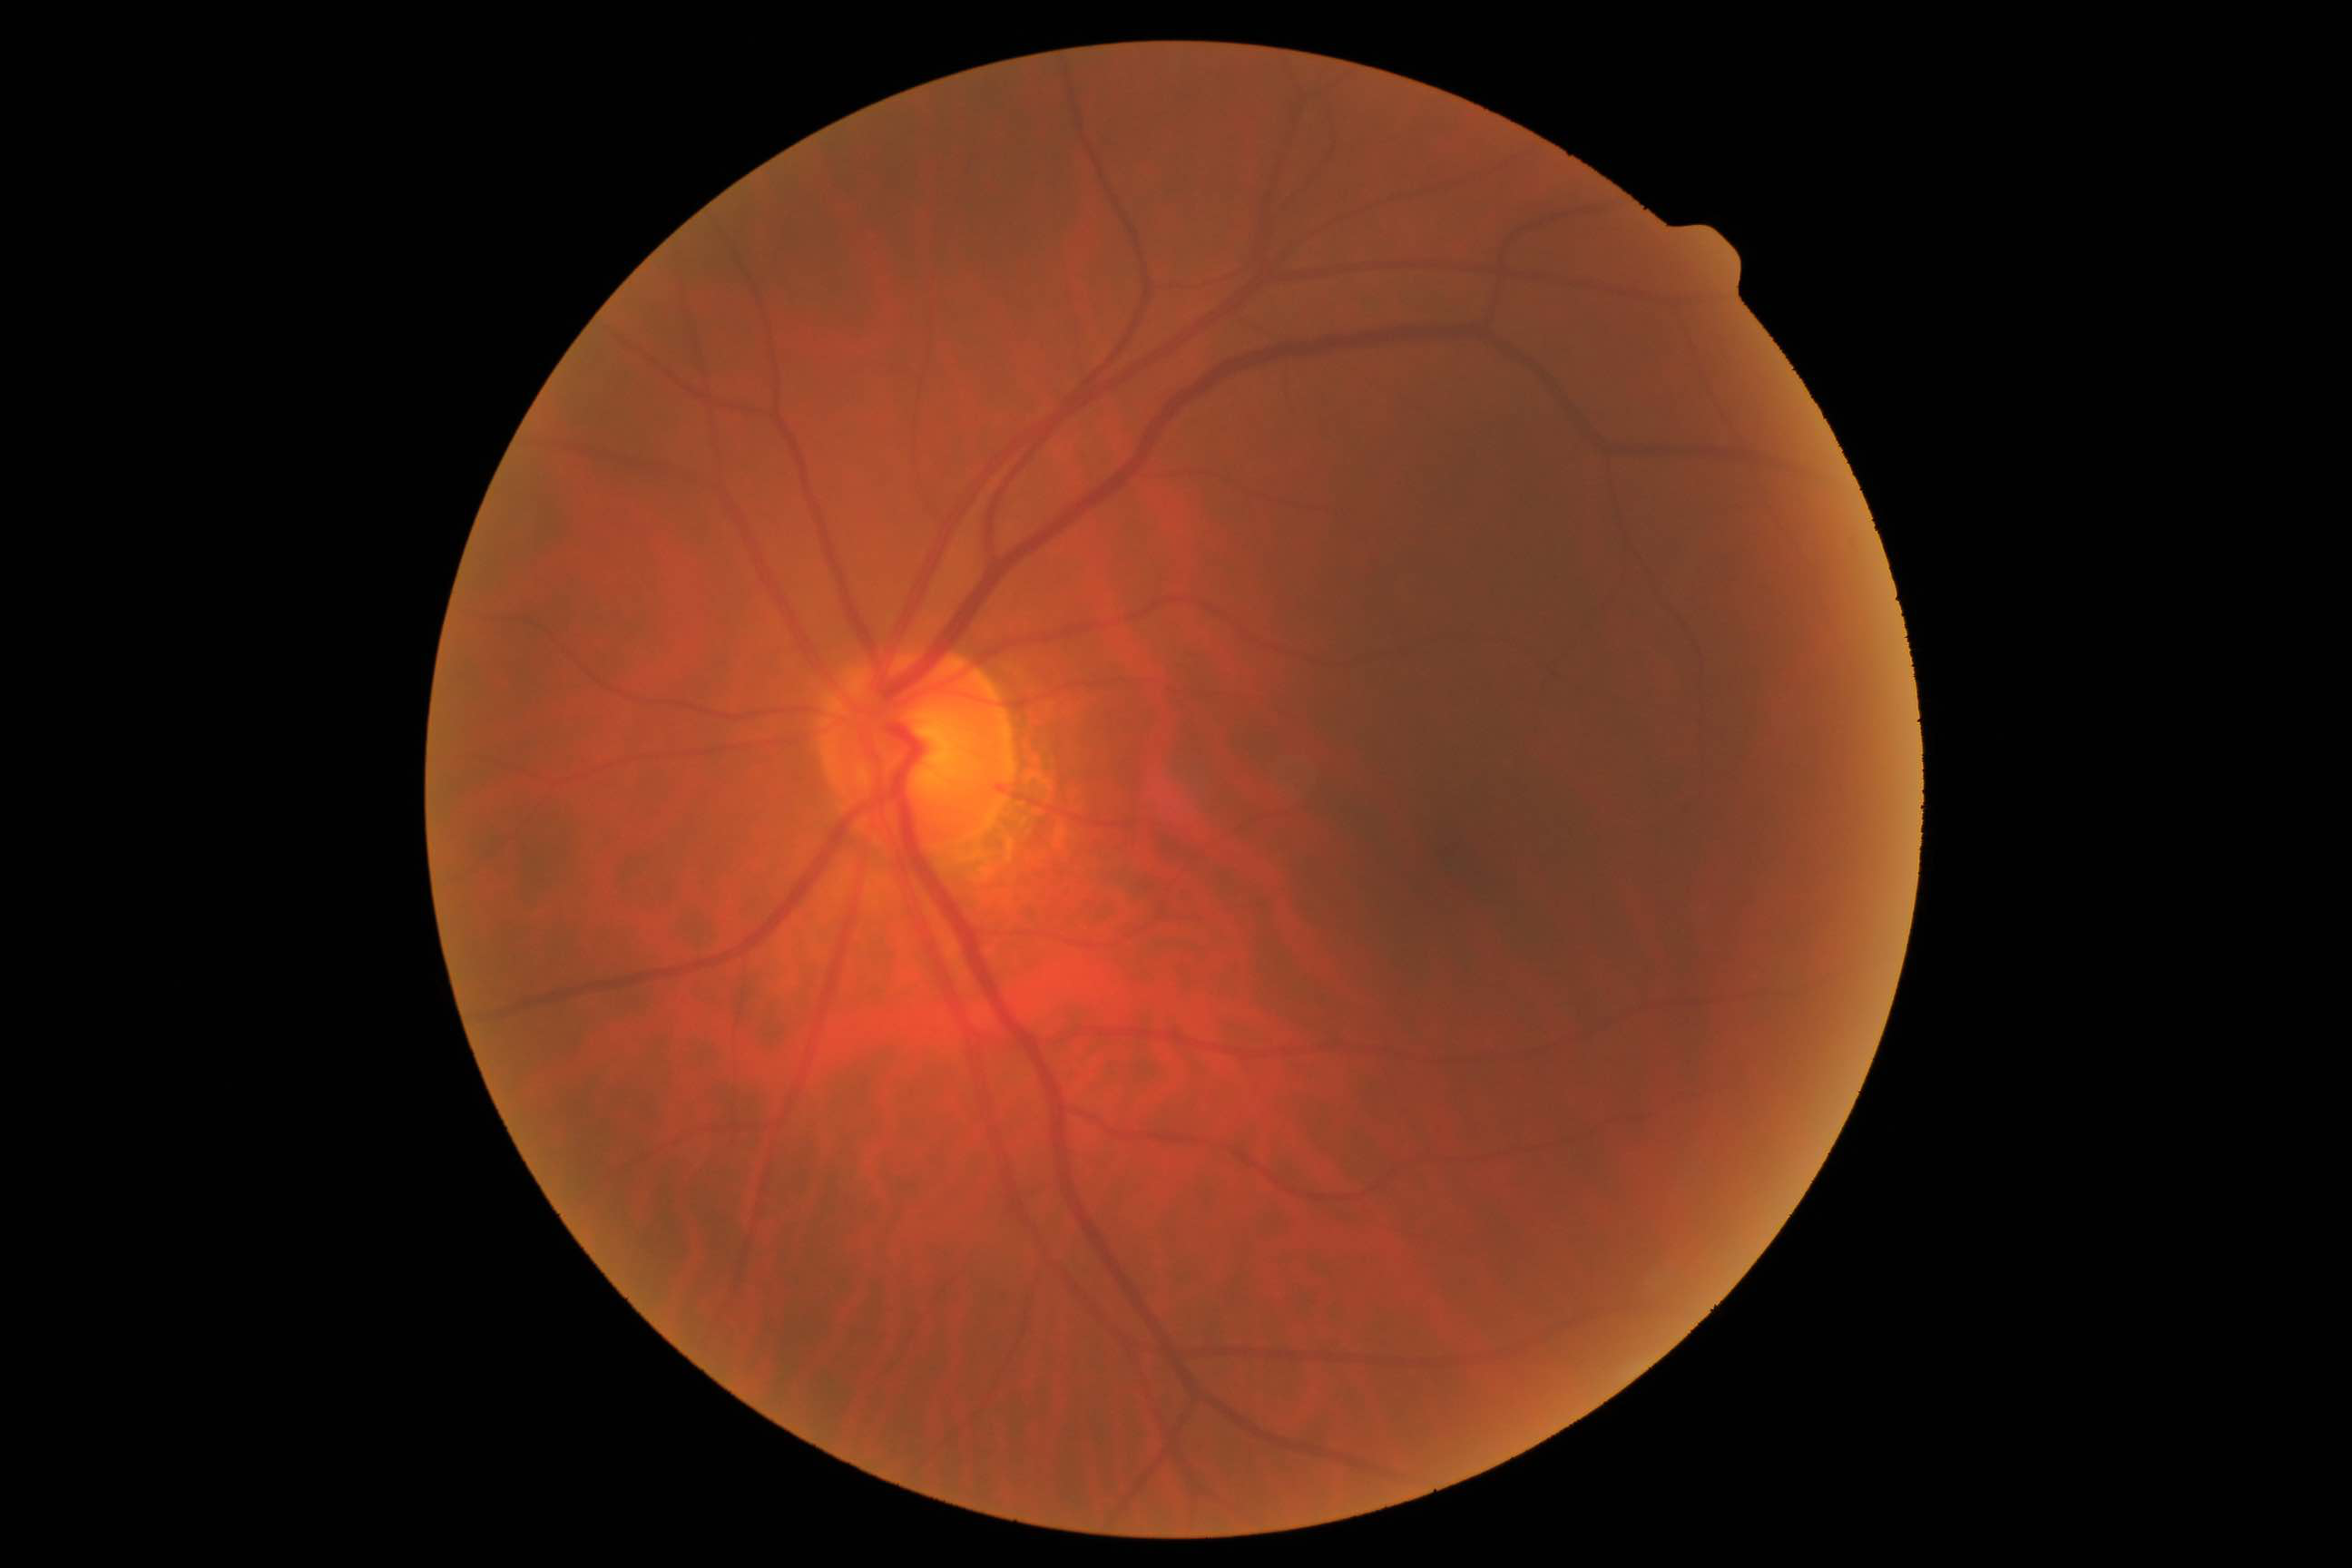

In [9]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpeg"))
image_path_list

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

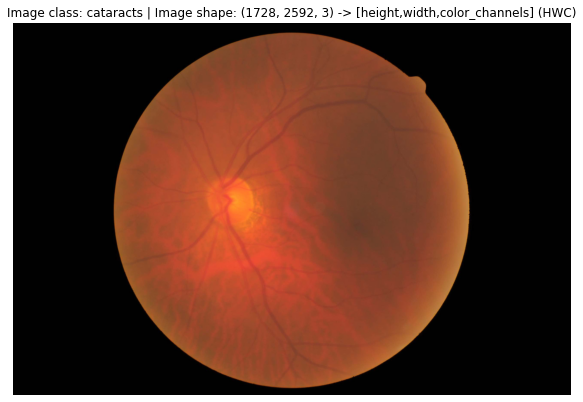

In [10]:
# Visualize with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height,width,color_channels] (HWC)")
plt.axis(False);

In [11]:
# Show the image in numerical format
img_as_array

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)

### 3.0. Transforming data

Before we can use our image data with PyTorch:

1. Turn the target data into tensors (numerical representation of the images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader` and we will call them `Dataset` and `DataLoader`

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1. Transforming data with `torchvision.transforms`

Transforms help get images ready to be used with model/perform data augmentation.

In [31]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize image to 64x64 since we used tiny VGG architecture
    transforms.Resize(size=(512,512)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch tensor
    transforms.ToTensor()
])

In [32]:
data_transform(img)

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.

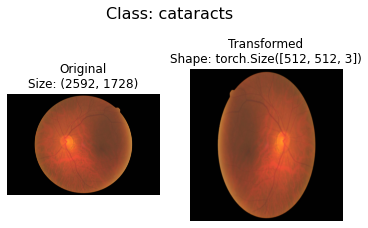

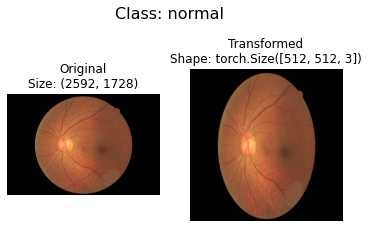

In [33]:
def plot_transformed_images(image_paths,transform,n=2,seed=42):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs. the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot the target image
      transformed_image = transform(f).permute(1,2,0) # Will need to change the shape for matplotlib (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=2,
                        seed=42)

### 4.0. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [34]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # A transform for the data
                                  target_transform=None) # A transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 318
     Root location: data/normal_cataracts/train
     StandardTransform
 Transform: Compose(
                Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 78
     Root location: data/normal_cataracts/test
     StandardTransform
 Transform: Compose(
                Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [35]:
train_dir, test_dir

(PosixPath('data/normal_cataracts/train'),
 PosixPath('data/normal_cataracts/test'))

In [36]:
# Get class names as list
class_names = train_data.classes
class_names

['cataracts', 'normal']

In [37]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'cataracts': 0, 'normal': 1}

In [38]:
# Class the lengths of our dataset
len(train_data), len(test_data)

(318, 78)

In [39]:
train_data.samples[0]

('data/normal_cataracts/train/cataracts/cataract_001.jpeg', 0)

In [40]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor:\n {img}")
print(f"Image Shape:\n {img.shape}")
print(f"Image Datatype:\n {img.dtype}")
print(f"Image Label:\n {label}")
print(f"Label Datatype:\n {type(label)}")

Image Tensor:
 tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0

In [41]:
class_names[label]

'cataracts'

Original Shape: torch.Size([3, 512, 512]) -> [color_channels, height, width]
Image Permute: torch.Size([512, 512, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'cataracts')

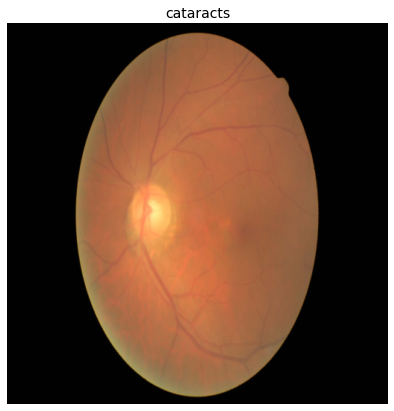

In [42]:
# Rearrange the other dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original Shape: {img.shape} -> [color_channels, height, width]")
print(f"Image Permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize=14)

### 4.1. Turn loaded images into `DataLoader`s

A `DataLoader` is going to help us turn our `Dataset`s into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [43]:
import os
os.cpu_count()

2

In [44]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fe88f664990>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe88f664910>)

In [45]:
len(train_dataloader), len(test_dataloader)

(318, 78)

In [46]:
len(train_data), len(test_data)

(318, 78)

In [47]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if wanted
print(f"Image Shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([1, 3, 512, 512]) -> [batch_size, color_channels, height, width]
Label Shape: torch.Size([1])


### 5.0. Option 2: Loading image data with a custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get class names as dictionary from Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it does not mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

In [48]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [49]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['cataracts', 'normal'], {'cataracts': 0, 'normal': 1})

### 5.1. Creating a helper function to get class names

Make a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)
2. Raise an error if the class names are not found (may be something wrong with the directory structure)
3. Turn the class names into a dict and a list and return them

In [50]:
# Set up path for target directory
target_directory = train_dir
print(f"Target Directory: {target_directory}")

# Get class names from target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Directory: data/normal_cataracts/train


['.DS_Store', 'cataracts', 'normal']

In [51]:
list(os.scandir(target_directory))

[<DirEntry 'normal'>, <DirEntry '.DS_Store'>, <DirEntry 'cataracts'>]

In [52]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Could not find any classes in {directory}... please check file structure.")
  
  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [53]:
find_classes(target_directory)

(['cataracts', 'normal'], {'cataracts': 0, 'normal': 1})

### 5.2. Create a custom `Dataset` to replicate `ImageFolder`

To create a custom dataset:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we want to get data from) as well as a transform if we want to transform the data
3. Create several attributes:
  * Paths - paths of the images
  * Transform - the transform we want to use
  * Classes - a list of our target classes
  * Class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()` to open images
5. Overwrite the `__len()__` method to return the length of the dataset
6. Overwrite the `__getitem()` method to return a given sample when passed an index

In [54]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize the custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Set up transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len()__
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)
    
  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # Expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]
    
    # Transform inf necessary
    if self.transform:
      return self.transform(img), class_idx # Return data, label (X, y)
    else:
      return img, class_idx # Return untransformed image and label

In [55]:
# Create a transform
from torchvision.transforms import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [56]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

In [57]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fe88f5687d0>,
 <__main__.ImageFolderCustom at 0x7fe88f819150>)

In [58]:
len(train_data), len(train_data_custom)

(318, 0)

In [59]:
len(test_data), len(test_data_custom)

(78, 0)

In [60]:
train_data_custom.classes

['cataracts', 'normal']

In [61]:
train_data_custom.class_to_idx

{'cataracts': 0, 'normal': 1}

In [62]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3. Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting out of hand, cap the number of images to see at 10
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset
5. Set up a Matplotlib plot
6. Loop through the random sample images and plot them with Matplotlib
7. Make sure the dimensions of the images line up with Matplotlib (HWC)

In [63]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, n should not be larger than 10, setting to 10 and removing shape display.")
  
  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Set up plot

  plt.figure(figsize=(16,8))

  # 6. Loop through random indexes and plot them with Matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0) # [C,H,W] -> [H,W,C]

    # Plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape {targ_image_adjust.shape}"
    plt.title(title)

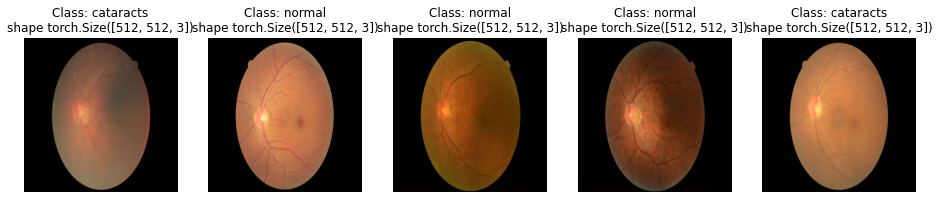

In [64]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

### 5.4. Turn custom loaded images into `DataDoader`s

In [66]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom

ValueError: ignored